In [1]:
# geometry-fused persistence diagram matching implementation
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_trefoil = [np.genfromtxt('../data/trefoil/tref_sc_100_{}.txt'.format(index)) for index in range(20)]
t = [[el[0] for el in x] for x in X_trefoil]

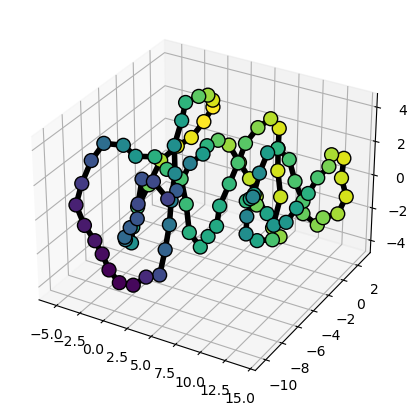

In [3]:
data = X_trefoil[1]
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(data[:,1], data[:,0],data[:,2],s=100,edgecolors='black',alpha = 1, c = t[1])
ax.plot(data[:,1], data[:,0],data[:,2], linewidth=4, c = 'black')
plt.show()

In [4]:
len(X_trefoil)

20

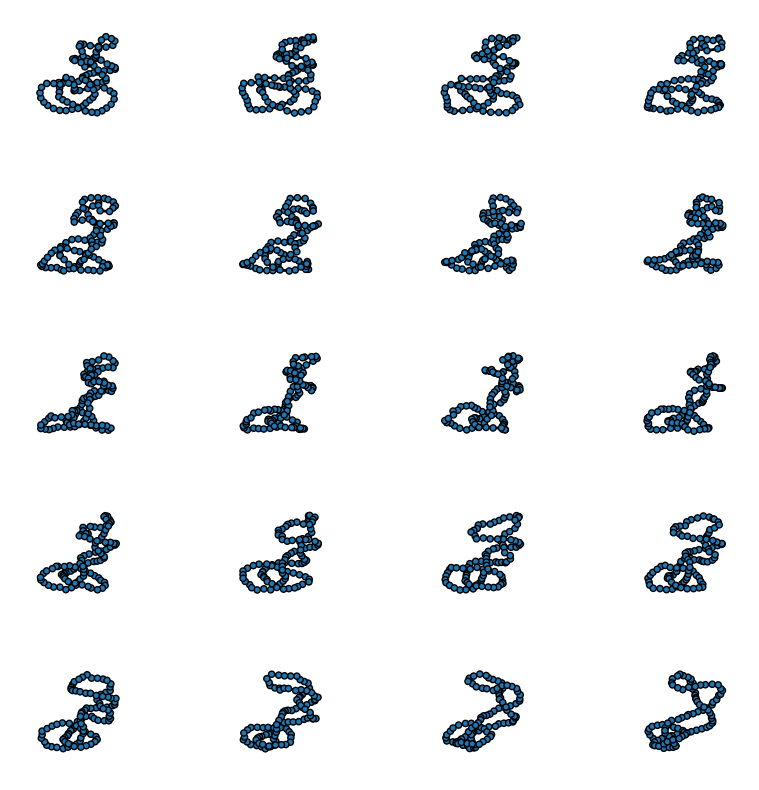

In [5]:
fig = plt.figure(figsize = (10, 10))
for i in range(0,len(X_trefoil)):
    # fig = plt.figure(figsize =(5, 4))
    A = X_trefoil[i]
    A = list(A)
    A.append(A[0])
    A = np.array(A)
    ax = fig.add_subplot(5, 4, i+1, projection='3d')
    scat = ax.scatter(A[:,1], A[:,0],A[:,2],s=20,edgecolors='black',alpha = 1,)
    ax.plot(A[:,1], A[:,0],A[:,2], linewidth=2, c = 'black')
    ax.set_axis_off()
    ax.view_init(elev=270, azim=0, roll=0)
plt.show()

In [6]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic    

In [7]:
H_all = [PH(x) for x in tqdm(X_trefoil)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:04<00:00, 15.24s/it]


In [8]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [9]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [10]:
TOP_matchings = []
GEO_matchings = []
SOURCE = []
TARGET = []
VERT_matchings = []
h = 0.25

for i in range(len(X_trefoil)-1):
    j = i+1
    # topological matching 
    df1 = topo_util.make_dataframe(H_all[i]["barcode"])
    df2 = topo_util.make_dataframe(H_all[j]["barcode"])
    p_spt = df1.iloc[:, 0:2].to_numpy()
    q_spt = df2.iloc[:, 0:2].to_numpy()
    p, q = pd.augmented_weights(p_spt, q_spt)
    C = pd.augmented_cost(p_spt, q_spt); C /= C.mean()
    pi = ot.emd(p, q, C)
    # TPOT matching 
    y0, w0, v0 = topo_util.process_hg(G_all[i], X_trefoil[i].shape[0])
    y1, w1, v1 = topo_util.process_hg(G_all[j], X_trefoil[j].shape[0])
    K0 = topo_util.get_kernel(X_trefoil[i], h)
    L0 = topo_util.symmetric_laplacian(K0)
    K0 /= K0.sum(-1).reshape(-1, 1)
    K1 = topo_util.get_kernel(X_trefoil[j], h)
    L1 = topo_util.symmetric_laplacian(K1)
    K1 /= K1.sum(-1).reshape(-1, 1)
    # impute generator hyperedges
    y0_imputed = topo_util.impute_laplacian(y0, L0)
    y1_imputed = topo_util.impute_laplacian(y1, L1)
    y0 = y0_imputed; y1 = y1_imputed;
    TARGET.append(y1)
    SOURCE.append(y0)
    # setup cost matrices
    C_v0 = sp.spatial.distance.cdist(X_trefoil[i], X_trefoil[i], metric = "euclidean"); C_v0 /= np.mean(C_v0)
    # C_v0 = np.exp(-C_v0)
    C_v1 = sp.spatial.distance.cdist(X_trefoil[j], X_trefoil[j], metric = "euclidean"); C_v1 /= np.mean(C_v1)
    # C_v1 = np.exp(-C_v1)
    C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)
    v0 = p
    v1 = q
    pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                              C_v0, C_v1, C_pd, 
                              alpha = 0.5, beta = 10.0, print_iter = 50, iter = 100, 
                              eps_s = 0, eps_f = 0,
                              solver = "exact")
    # pi_f = ot.emd(v0, v1, pi_f.max() - pi_f)
    # pi_s = ot.emd(w0, w1, pi_s.max() - pi_s)
    t0, t1 = t, t
    P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
    Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
    Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
    Q[np.isnan(Q)] = 0
    Q_pd[np.isnan(Q_pd)] = 0
    TOP_matchings.append(Q_pd)
    GEO_matchings.append(Q)
    VERT_matchings.append(P)

Iteration 0,	 obj = 0.11142092569983682,	 obj_terms = {'coot': 0.09400321025068845, 'ot': 0.01586984359607755, 'gw': 0.0015478718530708244}
is_converged, obj = 0.09825977844391036, obj_new = 0.09825977844391036
Iteration 0,	 obj = 0.17781188264551173,	 obj_terms = {'coot': 0.1469362839508895, 'ot': 0.02975527266953218, 'gw': 0.0011203260250900438}
is_converged, obj = 0.16109082582911838, obj_new = 0.16109082582911838
Iteration 0,	 obj = 0.14896456467895164,	 obj_terms = {'coot': 0.11870828486847887, 'ot': 0.028689756242937896, 'gw': 0.0015665235675348793}
is_converged, obj = 0.13160025825566862, obj_new = 0.13160025825566862
Iteration 0,	 obj = 0.16701795838450761,	 obj_terms = {'coot': 0.13967262673227193, 'ot': 0.026070388481112376, 'gw': 0.0012749431711233112}
is_converged, obj = 0.15182603864654087, obj_new = 0.15182603864654087
Iteration 0,	 obj = 0.10085076712427307,	 obj_terms = {'coot': 0.09023187499236104, 'ot': 0.009379228434752175, 'gw': 0.0012396636971598474}
is_converged, 

/tmp/ipykernel_690551/3981044655.py:50: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_690551/3981044655.py:51: RuntimeWarning:

invalid value encountered in divide



Iteration 0,	 obj = 0.1530252345418237,	 obj_terms = {'coot': 0.13781255297181913, 'ot': 0.013696170394234805, 'gw': 0.0015165111757697778}
is_converged, obj = 0.14044630098197128, obj_new = 0.14044630098197128
Iteration 0,	 obj = 0.14754493771454022,	 obj_terms = {'coot': 0.11742890235200192, 'ot': 0.028418239074934938, 'gw': 0.0016977962876033586}
is_converged, obj = 0.12737536748764164, obj_new = 0.12737536748764164
Iteration 0,	 obj = 0.11549408947782698,	 obj_terms = {'coot': 0.09027320237220363, 'ot': 0.022682023970342066, 'gw': 0.0025388631352812924}
is_converged, obj = 0.09548842165014887, obj_new = 0.09548842165014887
Iteration 0,	 obj = 0.3386905693295609,	 obj_terms = {'coot': 0.24296861503050296, 'ot': 0.09348214905437748, 'gw': 0.0022398052446804223}
is_converged, obj = 0.33445290145035744, obj_new = 0.33445290145035744
Iteration 0,	 obj = 0.2367165086479527,	 obj_terms = {'coot': 0.1846999894966521, 'ot': 0.05003421936707345, 'gw': 0.001982299784227166}
is_converged, obj 

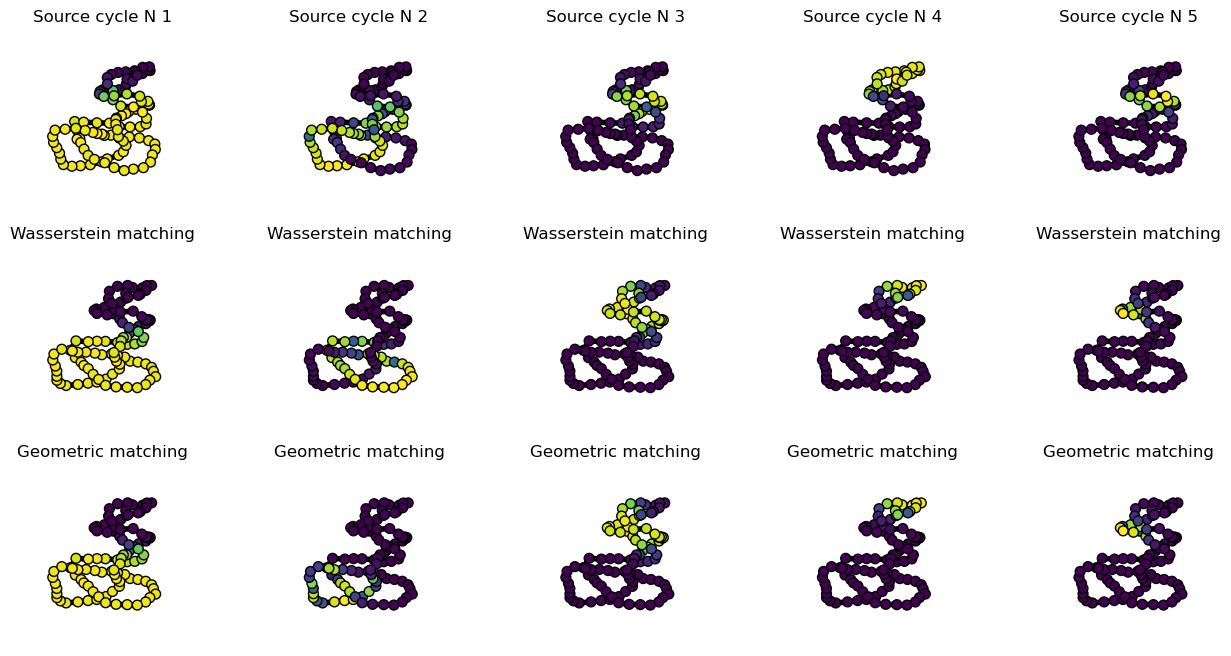

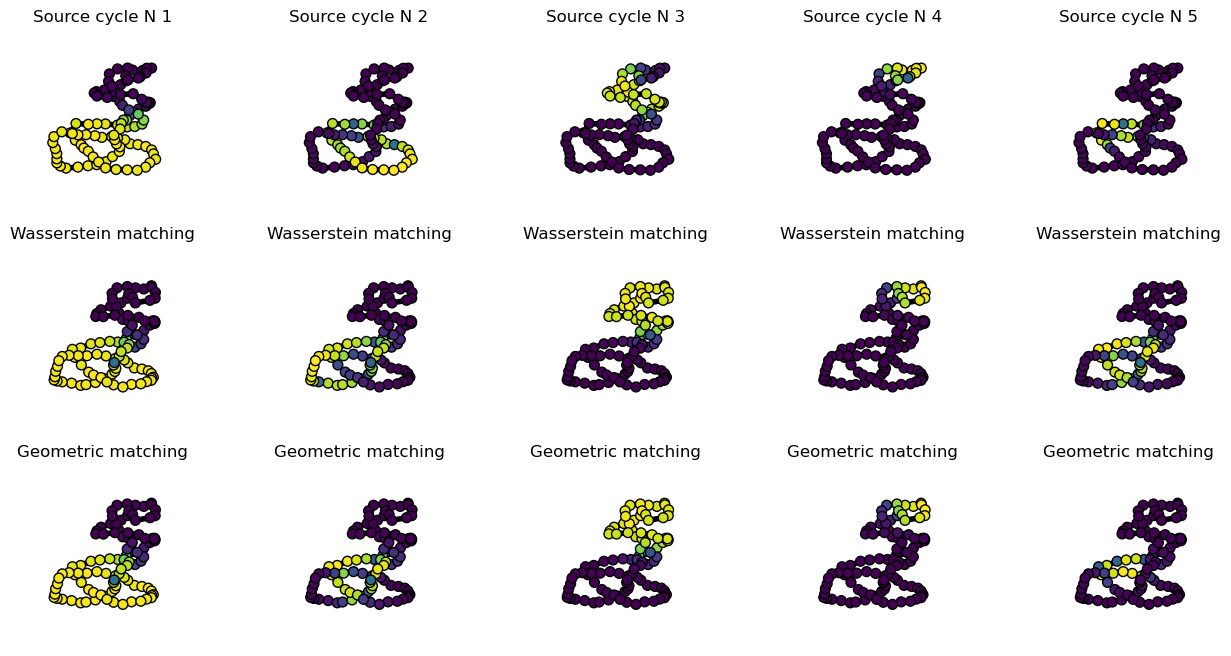

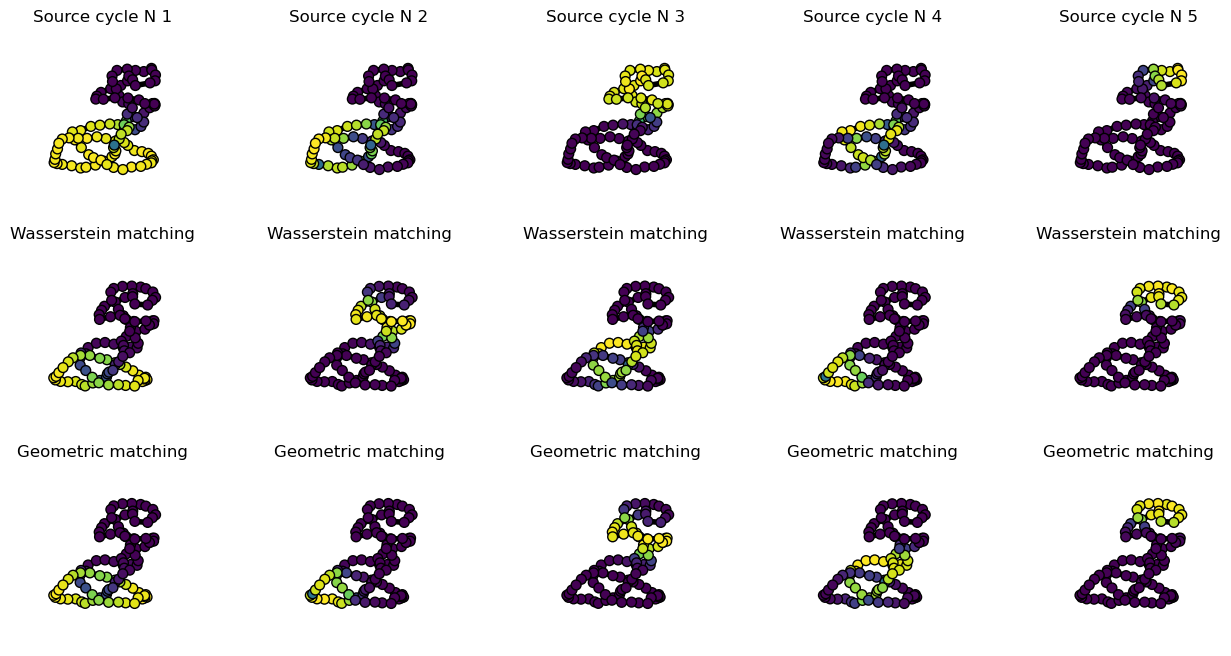

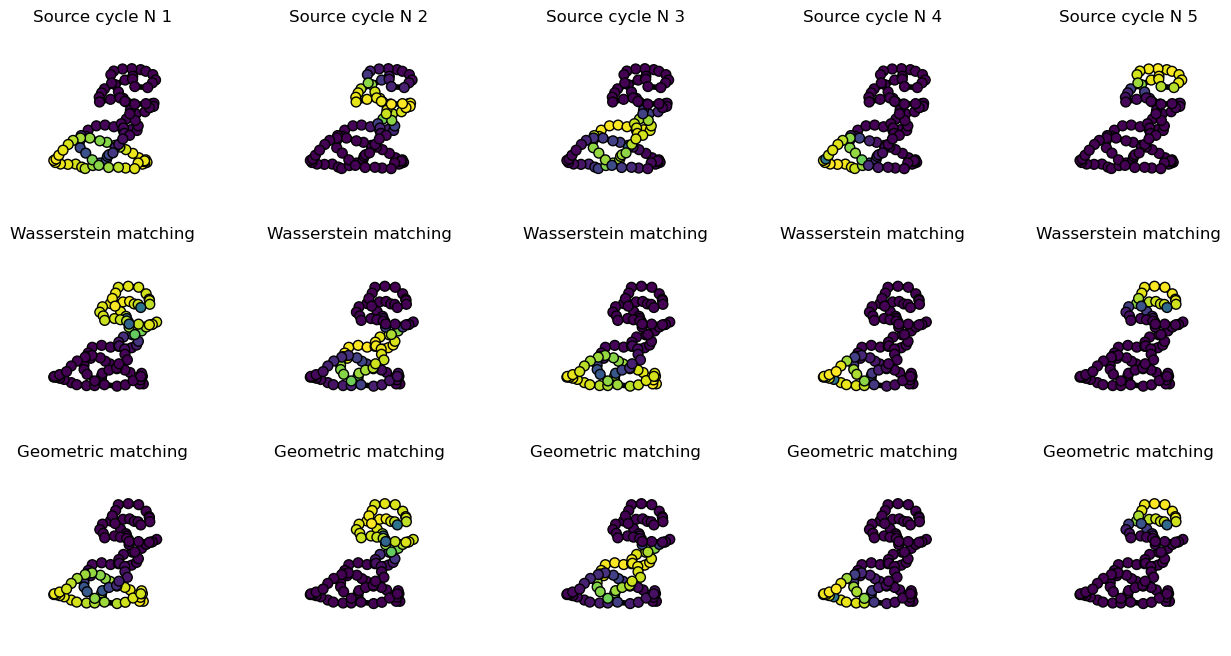

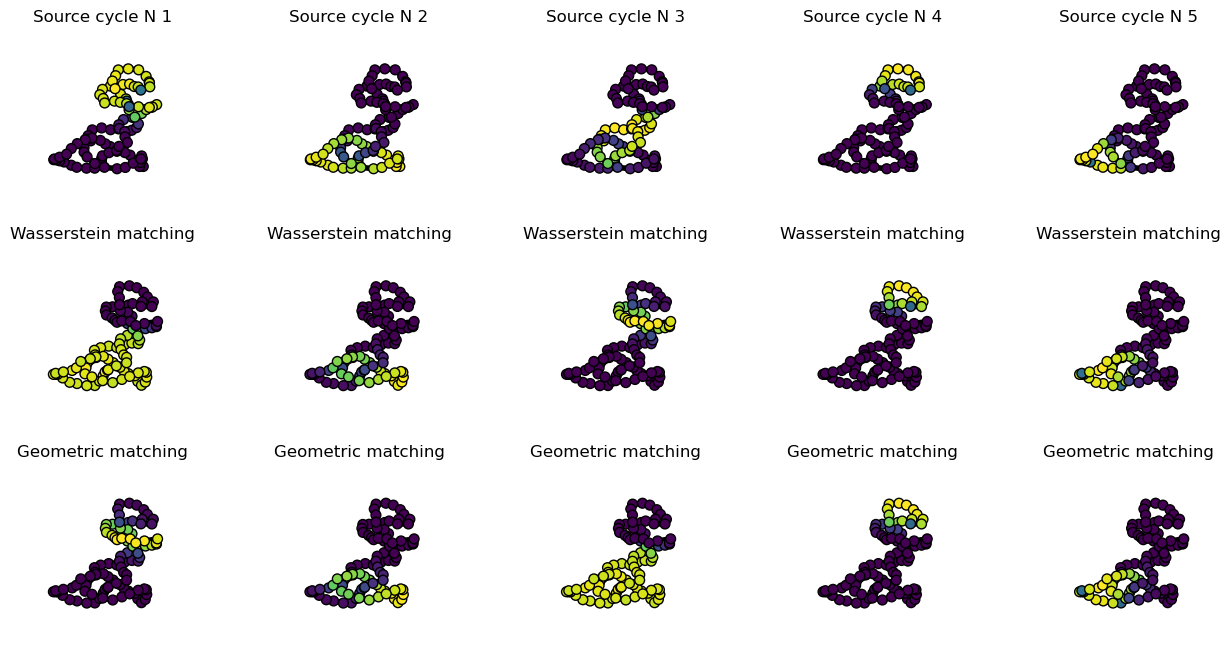

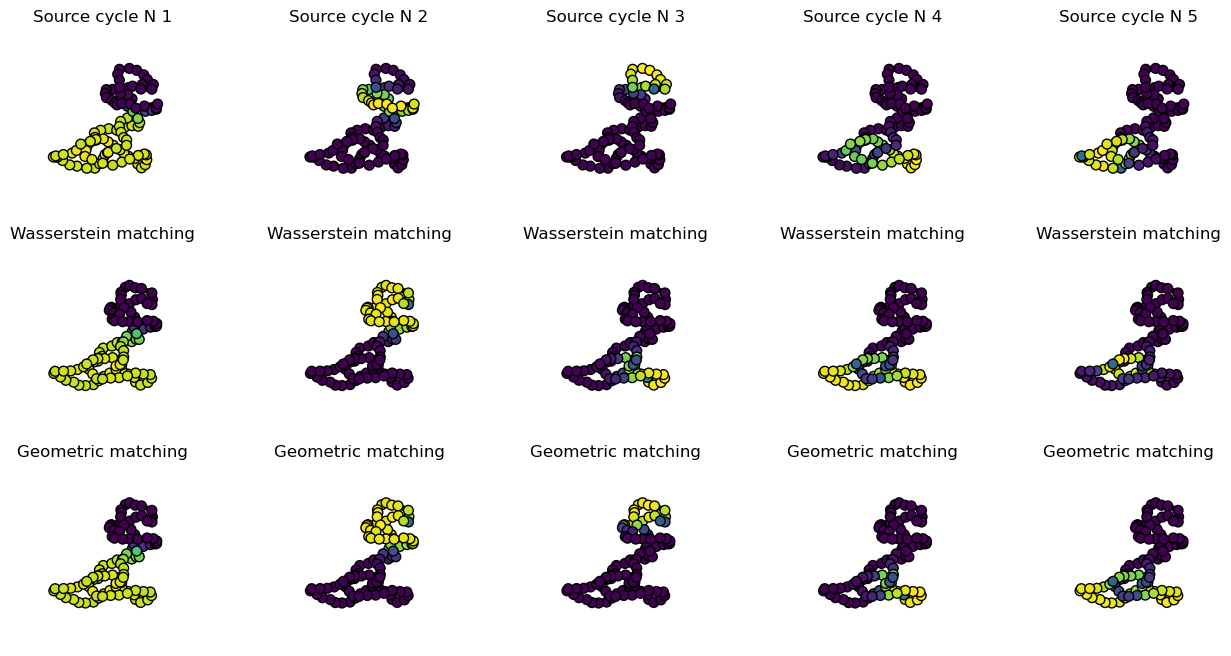

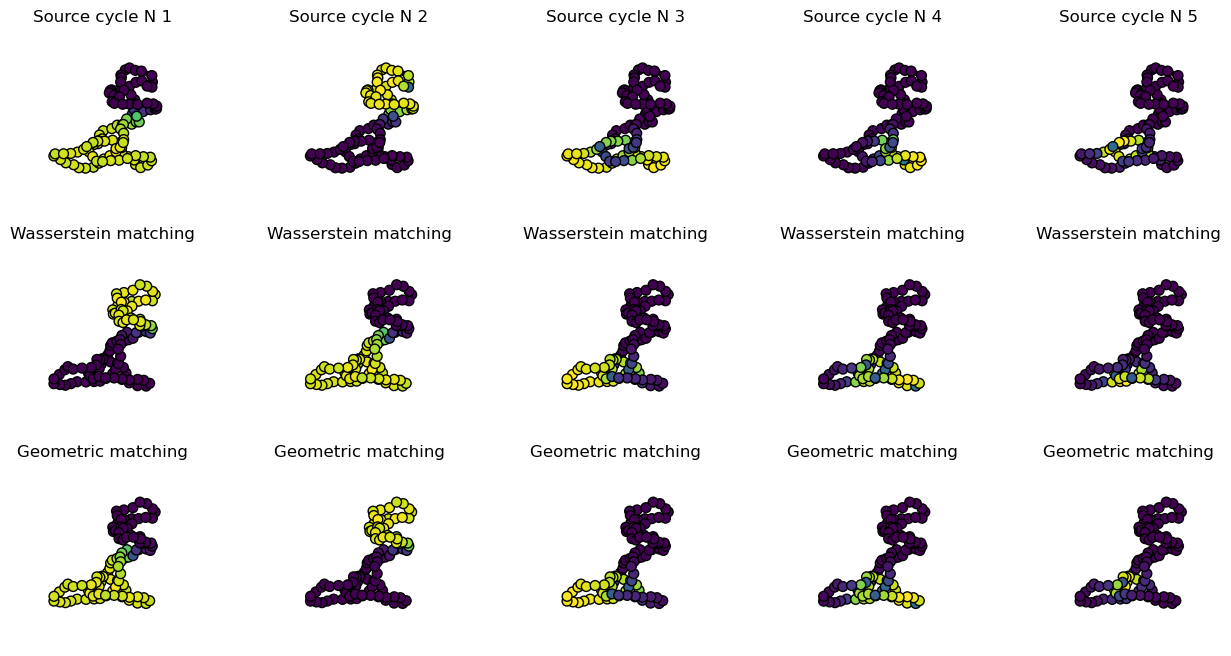

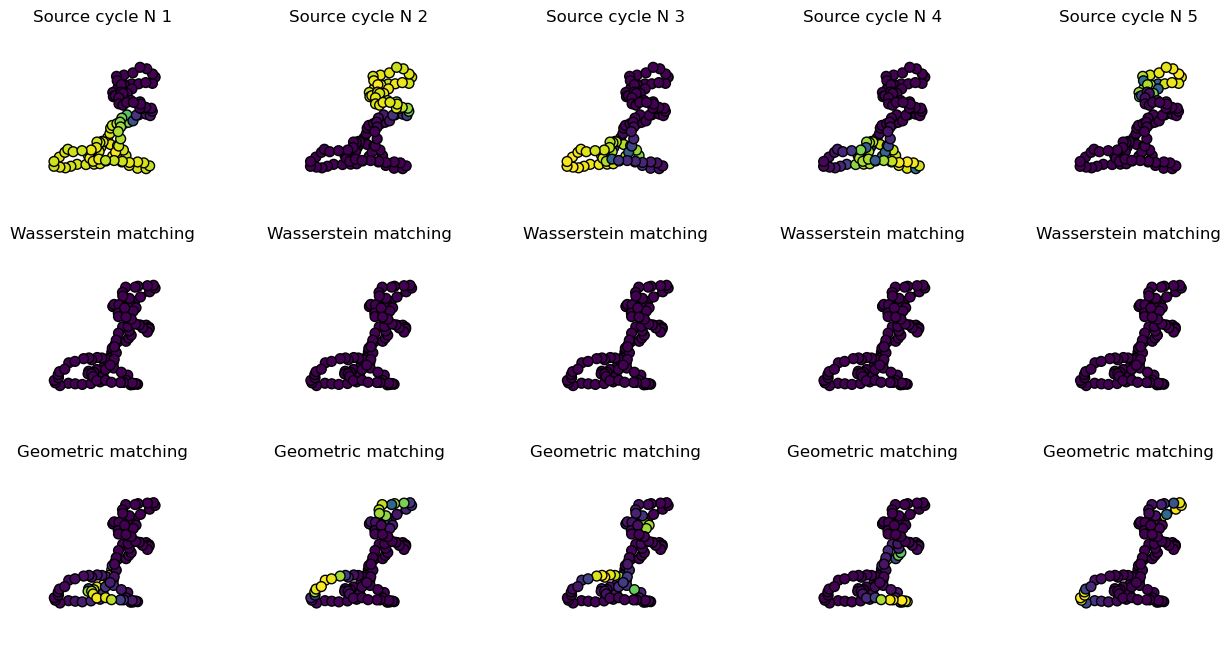

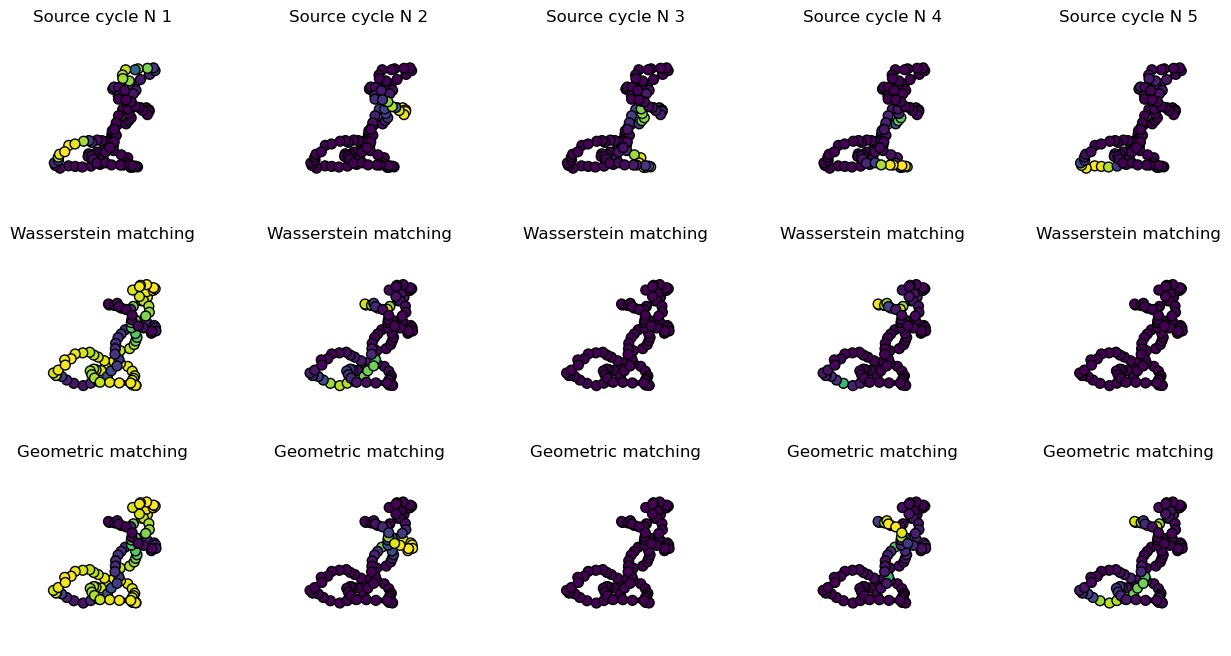

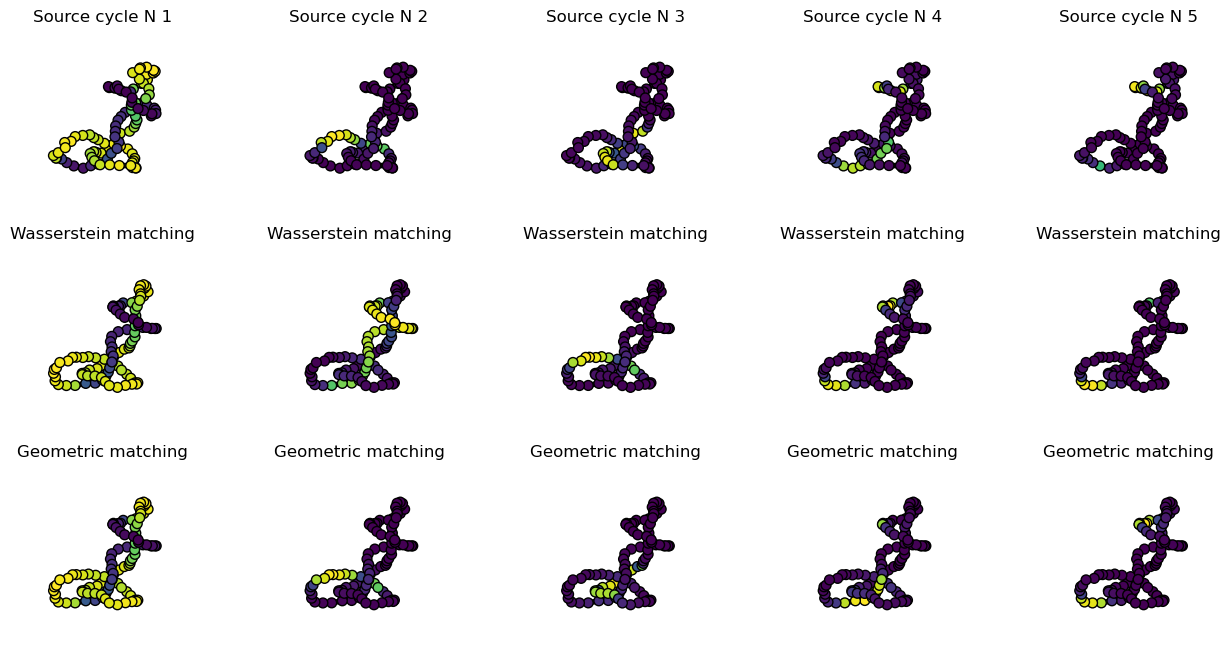

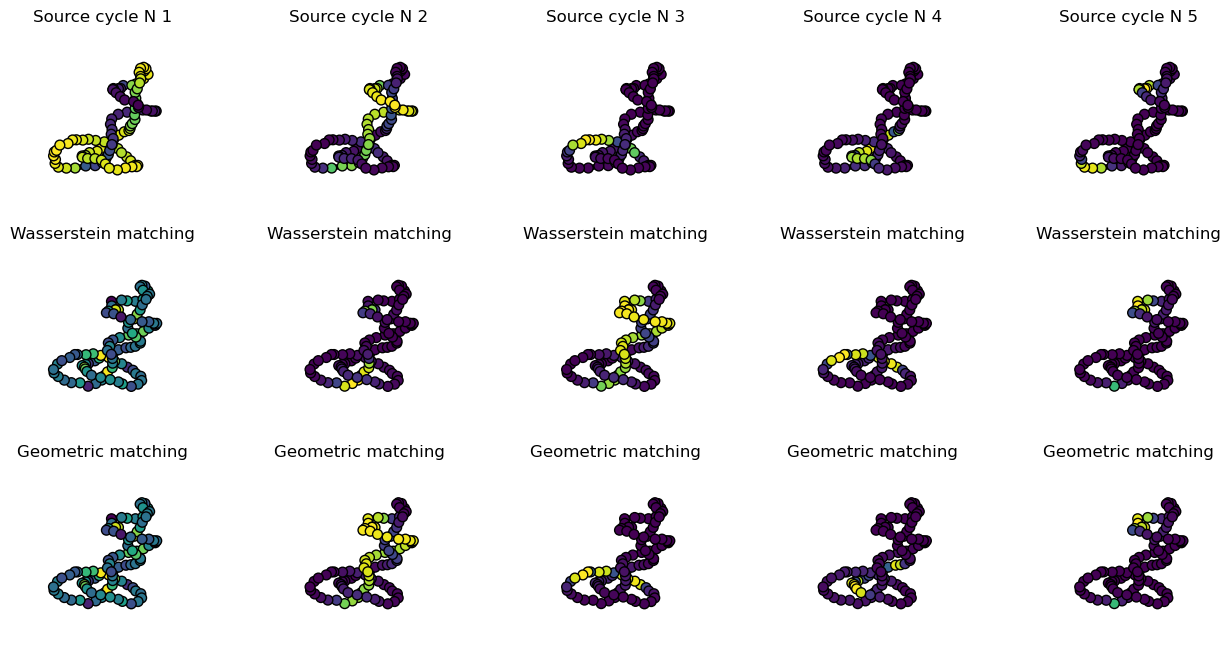

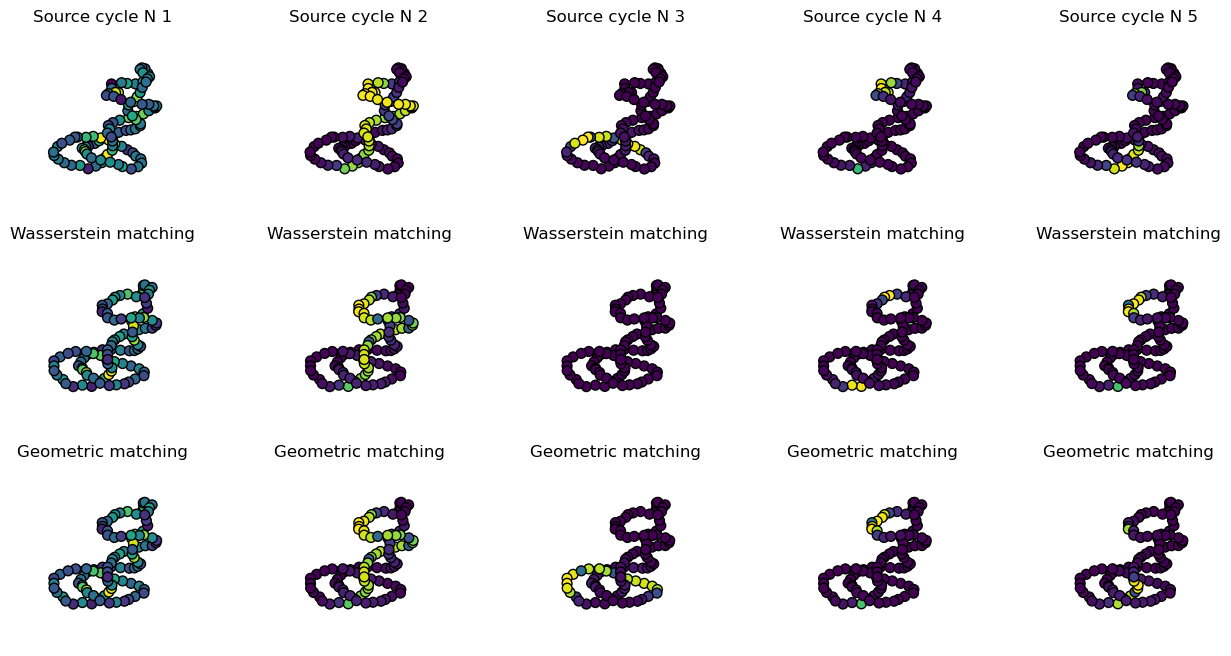

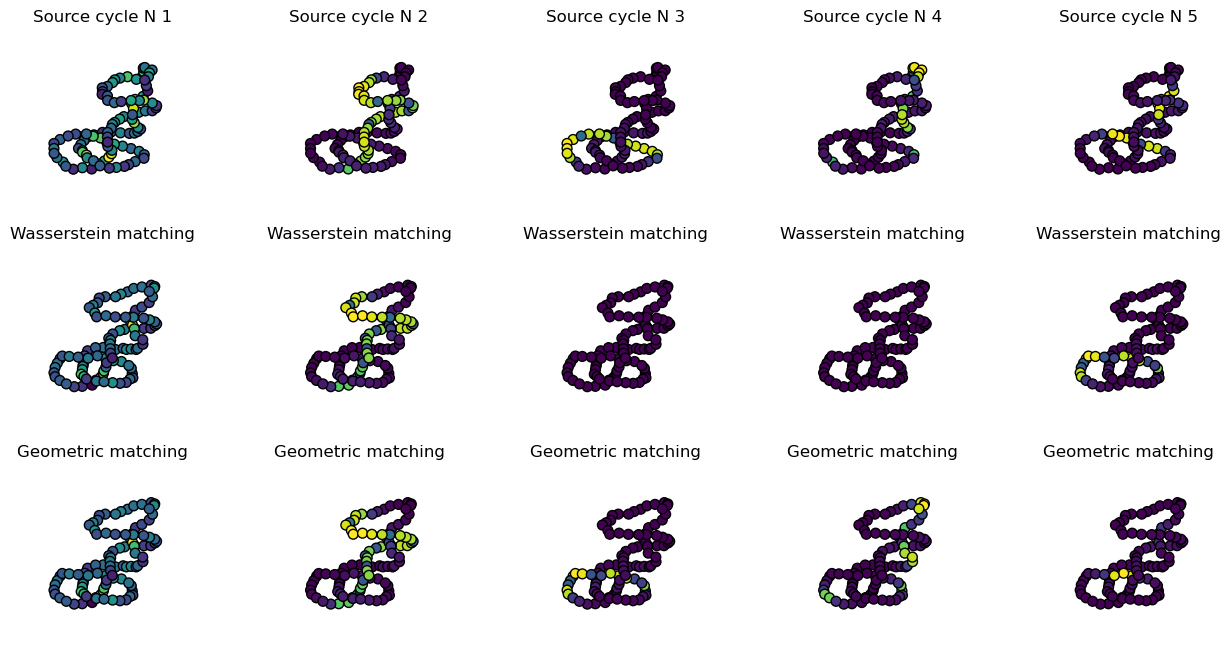

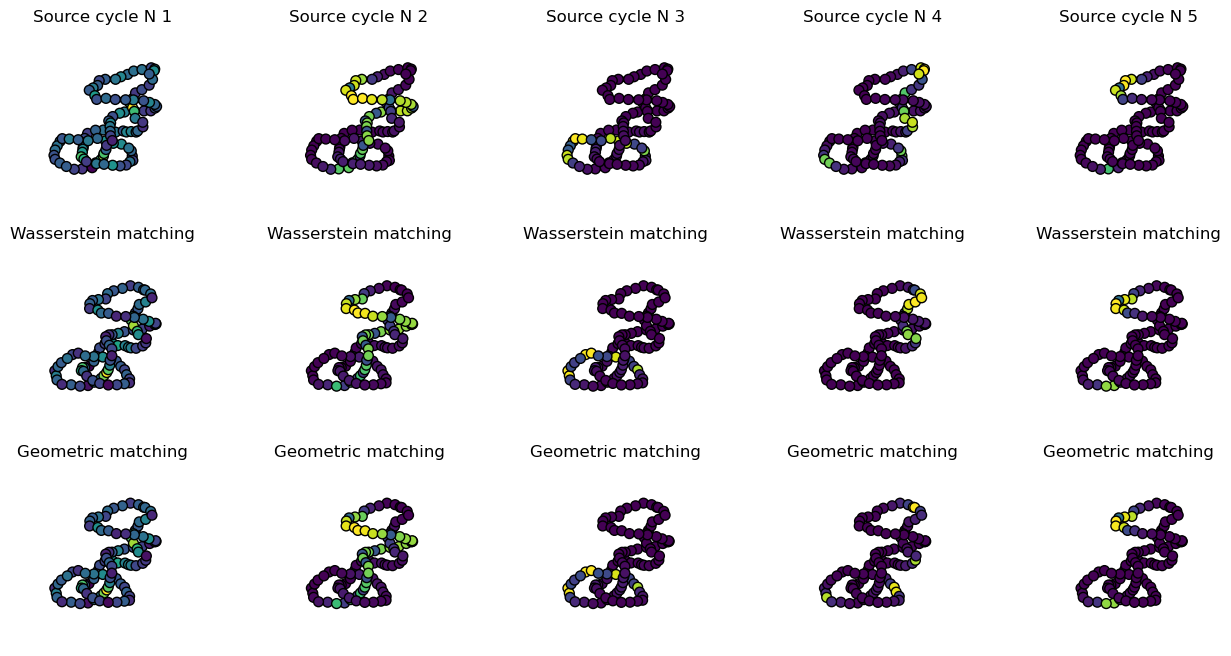

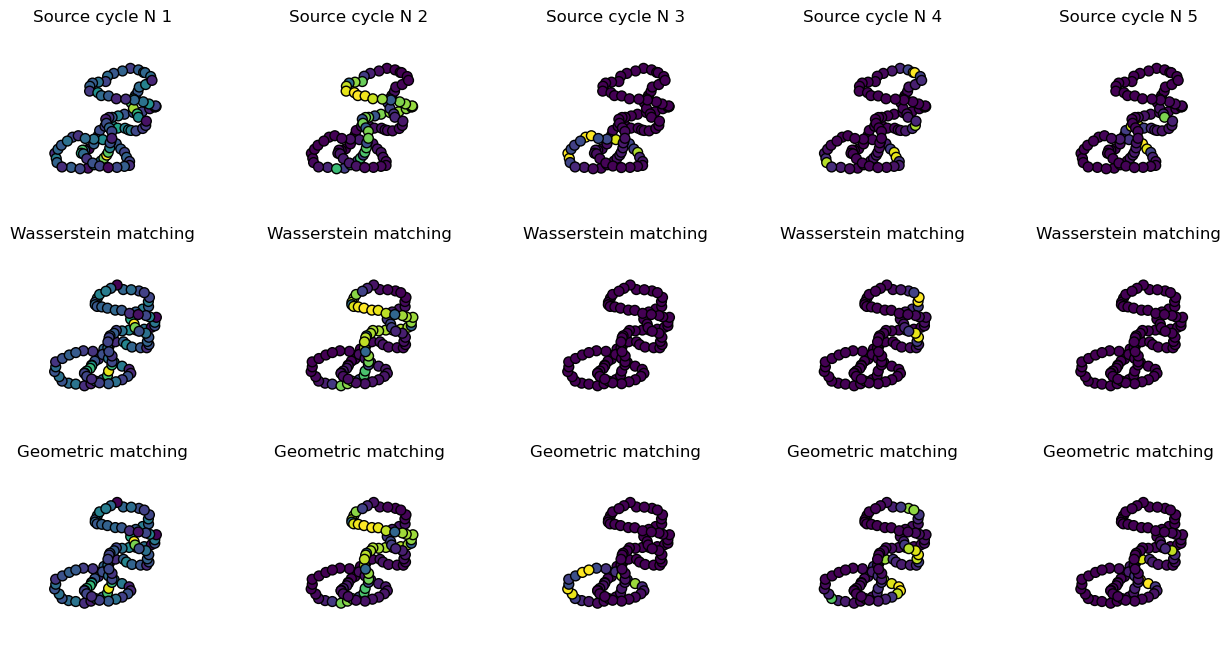

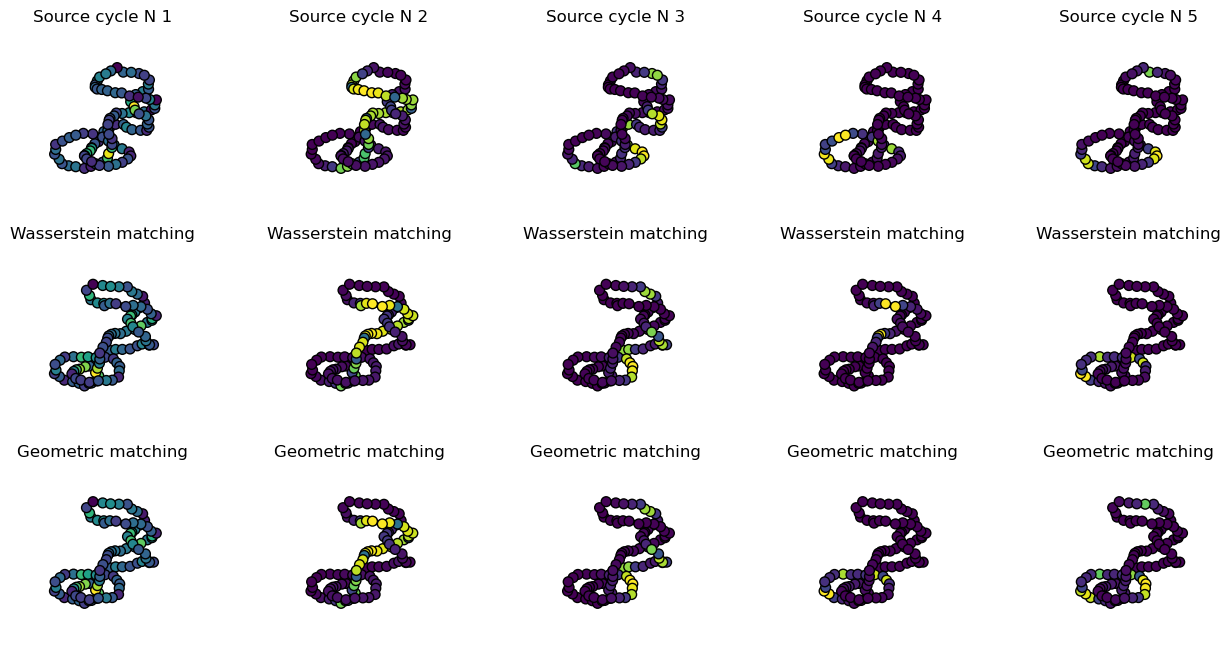

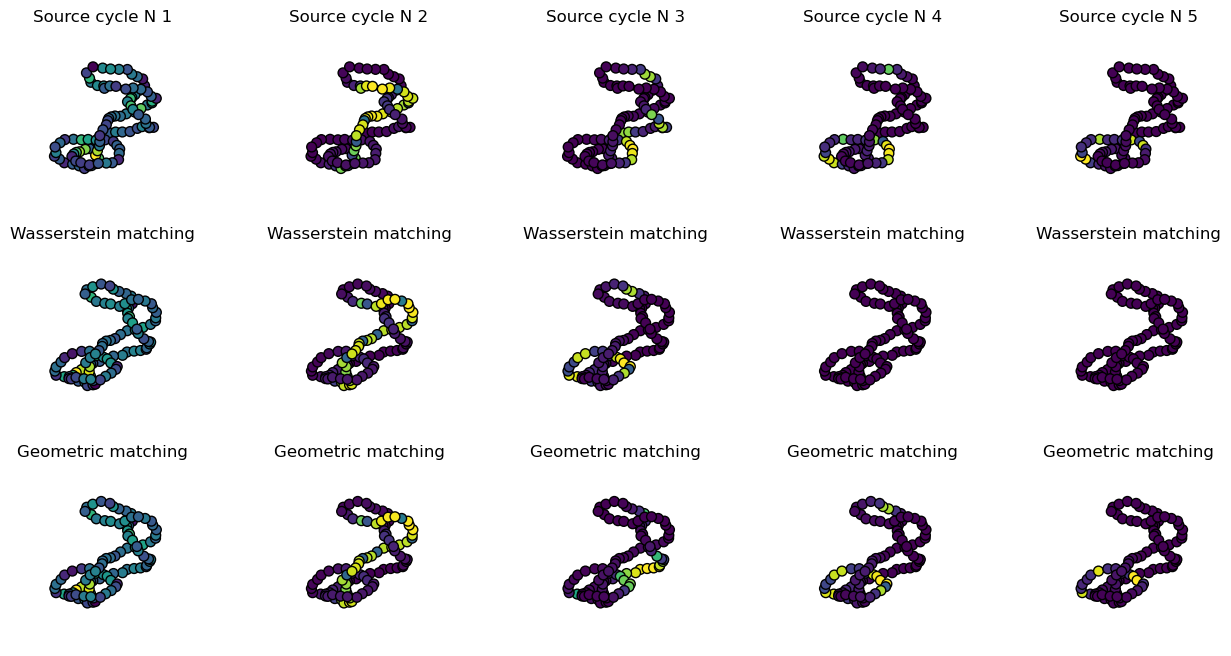

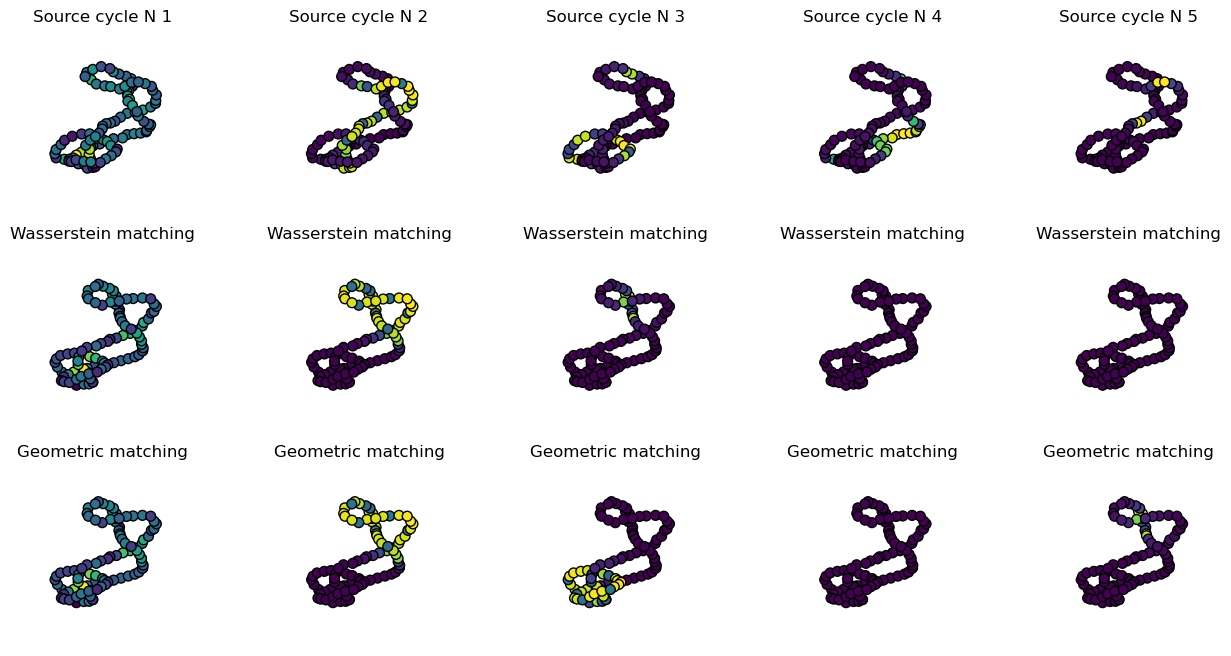

In [11]:
for i in range(1,len(X_trefoil)-1):
    y0 = SOURCE[i]
    Q = GEO_matchings[i]
    Q_pd = TOP_matchings[i]
    y1 = TARGET[i]
    A = X_trefoil[i]
    B = X_trefoil[i+1]
    fig = plt.figure(figsize=plt.figaspect(0.5))
    for l in range(1,6):
        ax = fig.add_subplot(3, 5, l,projection='3d')
        scat = ax.scatter(A[:,1], A[:,0],A[:,2],s=50,edgecolors='black',alpha = 1, c = y0[:, -l],)
        ax.plot(A[:,1], A[:,0],A[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()
        ax.view_init(elev=270, azim=0, roll=0)
        plt.title("Source cycle N {}".format(l))
        ax = fig.add_subplot(3, 5, l+5,projection='3d')
        scat = ax.scatter(B[:,1], B[:,0],B[:,2],s=50,edgecolors='black',alpha = 1, c = (Q_pd[-l, :].reshape(1, -1) * y1).sum(-1),)
        ax.plot(B[:,1], B[:,0],B[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()
        ax.view_init(elev=270, azim=0, roll=0)
        plt.title("Wasserstein matching")
        ax = fig.add_subplot(3, 5, l+10,projection='3d')
        scat = ax.scatter(B[:,1], B[:,0],B[:,2],s=50,edgecolors='black',alpha = 1, c = (Q[-l, :].reshape(1, -1) * y1).sum(-1),)
        ax.plot(B[:,1], B[:,0],B[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()    
        ax.view_init(elev=270, azim=0, roll=0)
        plt.title("Geometric matching")
    fig.savefig('../outputs/trefoil_step{}.pdf'.format(i))
    plt.show()

In [12]:
corr = []
corr1 = []
pers = []
for i in range(len(X_trefoil)-1):
    y0 = SOURCE[i]
    Q = GEO_matchings[i]
    Q_pd = TOP_matchings[i]
    y1 = TARGET[i]
    A = X_trefoil[i]
    B = X_trefoil[i+1]
    for l in range(1,len(Q_pd)+1):
        corr1.append(np.corrcoef((Q_pd[-l, :].reshape(1, -1) * np.array(y1)).sum(-1), y0[:, -l])[0][1])
        corr.append(np.corrcoef((Q[-l, :].reshape(1, -1) * np.array(y1)).sum(-1), y0[:, -l])[0][1] ) 
        pers.append(H_all[i]['barcode'][1][-l] - H_all[i]['barcode'][0][-l])

corr = np.array(corr)
corr[np.isnan(corr)] = 0
corr1 = np.array(corr1)
corr1[np.isnan(corr1)] = 0

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



In [13]:
DF = pandas.DataFrame()
DF['Correlation'] = np.concatenate([corr1, corr])
DF['Type'] = np.concatenate([len(corr)*['Wasserstein'], len(corr)*['Geometric']])
DF['Persistence'] = np.concatenate([pers, pers])
DF

Correlation         Type  Persistence
0       0.939845  Wasserstein     2.920049
1       0.729630  Wasserstein     2.335883
2       0.735841  Wasserstein     2.051982
3       0.951080  Wasserstein     1.629752
4       0.525746  Wasserstein     1.306470
..           ...          ...          ...
743     0.000000    Geometric     0.591863
744    -0.059151    Geometric     0.059718
745     0.178880    Geometric     0.033733
746     0.000000    Geometric     0.012892
747     0.000000    Geometric     0.006359

[748 rows x 3 columns]

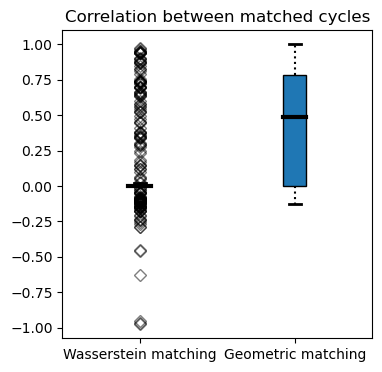

In [14]:
data = [DF.loc[DF['Type'] == 'Wasserstein']['Correlation'], 
        DF.loc[DF['Type'] == 'Geometric']['Correlation']]

fig = plt.figure(figsize =(4, 4))
ax = fig.add_subplot(111)
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='black',
              alpha = 0.5)
# x-axis labels
ax.set_xticklabels(['Wasserstein matching', 'Geometric matching'])
# Adding title 
plt.title("Correlation between matched cycles")
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
fig.savefig('../outputs/trefoil_corr.pdf')     
# show plot
plt.show()

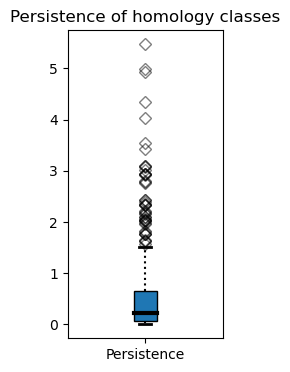

In [15]:
data = [DF.loc[DF['Type'] == 'Wasserstein']['Persistence']]
fig = plt.figure(figsize =(2, 4))
ax = fig.add_subplot(111)
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='black',
              alpha = 0.5)
# x-axis labels
ax.set_xticklabels(['Persistence', 
                    ])
# Adding title 
plt.title("Persistence of homology classes")
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
# fig.savefig('outputs/trefoil_per.pdf')     
# show plot
plt.show()

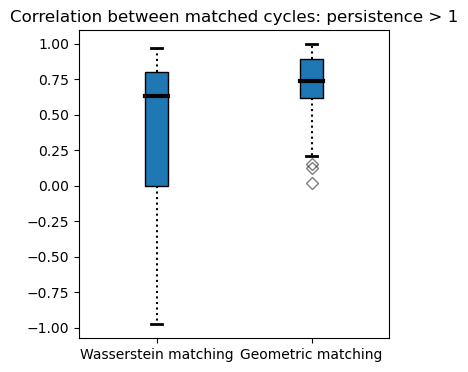

In [16]:
thresh = 1
D = DF.loc[DF['Persistence'] > thresh]
data = [D.loc[DF['Type'] == 'Wasserstein']['Correlation'], D.loc[D['Type'] == 'Geometric']['Correlation']]
fig = plt.figure(figsize =(4, 4))
ax = fig.add_subplot(111)
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='black',
              alpha = 0.5)
# x-axis labels
ax.set_xticklabels(['Wasserstein matching', 'Geometric matching'])
# Adding title 
plt.title(f"Correlation between matched cycles: persistence > {thresh}")
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
# fig.savefig('outputs/trefoil_corr_p.pdf')     
# show plot
plt.show()